In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
from influxdb import InfluxDBClient

import matplotlib.pyplot as plt

from utils_IO import get_data

# Data preprocessing

In [2]:
query = 'SELECT * FROM "EP_Battery.Thing_HMD8310"'
df = get_data(query)
df.head(10)

,time,AVG_PACK_SOC,AvgSOC,AvgSOH,BATT_PACK_1_DISCONN,BATT_PACK_1_FAULT,BATT_PACK_1_WARN,BATT_PACK_2_DISCONN,BATT_PACK_2_FAULT,BATT_PACK_2_WARN,...,PACK_1_STATUS,PACK_2_STATUS,PACK_3_STATUS,PACK_4_STATUS,PACK_5_STATUS,PACK_6_STATUS,PACK_7_STATUS,RunningState,Voltage,valuestreamname
0,2022-08-30T00:00:00Z,NaN,77.0,100.0,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,900.0,ISS.Onshore.Model.VS
1,2022-08-30T00:01:00Z,NaN,77.0,100.0,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,900.0,ISS.Onshore.Model.VS
2,2022-08-30T00:02:00Z,NaN,77.0,100.0,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,900.0,ISS.Onshore.Model.VS
3,2022-08-30T00:03:00Z,NaN,77.0,100.0,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,900.0,ISS.Onshore.Model.VS
4,2022-08-30T00:04:00Z,NaN,77.0,100.0,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,900.0,ISS.Onshore.Model.VS
5,2022-08-30T00:05:00Z,NaN,77.0,100.0,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,900.0,ISS.Onshore.Model.VS
6,2022-08-30T00:06:00Z,NaN,77.0,100.0,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,900.0,ISS.Onshore.Model.VS
7,2022-08-30T00:07:00Z,NaN,77.0,100.0,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,900.0,ISS.Onshore.Model.VS
8,2022-08-30T00:08:00Z,NaN,77.0,100.0,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,900.0,ISS.Onshore.Model.VS
9,2022-08-30T00:09:00Z,NaN,77.0,100.0,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,900.0,ISS.Onshore.Model.VS


In [3]:
df["time"].values[:10]

array(['2022-08-30T00:00:00Z', '2022-08-30T00:01:00Z',
       '2022-08-30T00:02:00Z', '2022-08-30T00:03:00Z',
       '2022-08-30T00:04:00Z', '2022-08-30T00:05:00Z',
       '2022-08-30T00:06:00Z', '2022-08-30T00:07:00Z',
       '2022-08-30T00:08:00Z', '2022-08-30T00:09:00Z'], dtype=object)

In [4]:
battery_data = df.copy()

date_format = '%Y-%m-%dT%H:%M:%SZ'
battery_data["time"] = battery_data.time.apply(datetime.strptime, args=(date_format, ))
battery_data.set_index("time", inplace=True)

## Noise fixing

In [99]:
df.iloc[idx-5:idx+5, 2:4]

,AvgSOC,AvgSOH
794,0.0,0.000
795,0.0,0.000
796,0.0,0.000
797,157550000.0,705.220
798,157610000.0,705.228
799,157670000.0,706.724
800,0.0,0.000
801,0.0,0.000
802,0.0,0.000
803,0.0,0.000


In [120]:
df.iloc[num_idx-6:num_idx+2, 2:4]

,AvgSOC,AvgSOH
47787,63.0,100.000000
47788,885.0,45.994832
47789,637.0,46.201550
47790,588.0,28.010336
47791,792.0,35.788114
47792,846.0,43.824289
47793,1087.0,50.258398
47794,67.0,100.000000


In [5]:
battery_data.loc[battery_data["AvgSOC"].idxmax(), "AvgSOC"]
# battery_data.loc[]
dt_idx = battery_data["AvgSOC"].idxmax()
num_idx = battery_data.index.get_loc(battery_data["AvgSOC"].idxmax())

In [6]:
battery_data.iloc[num_idx-2:num_idx+1, 1:3]

,AvgSOC,AvgSOH
time,,
2022-08-31 00:34:00,157550000.0,705.220
2022-08-31 00:35:00,157610000.0,705.228
2022-08-31 00:36:00,157670000.0,706.724


In [7]:
# Fix outlier in AvgSOC
battery_data.iloc[num_idx-2:num_idx+1, 1] = 0
# Fix outlier in AvgSOH
battery_data.iloc[num_idx-2:num_idx+1, 2] = 0

In [8]:
dt_idx = battery_data["AvgSOC"].idxmax()
num_idx = battery_data.index.get_loc(battery_data["AvgSOC"].idxmax())
print(dt_idx)
print(num_idx)
battery_data.iloc[num_idx-5:num_idx+2, 1]

2022-10-12 08:11:00
47793


time
2022-10-12 08:06:00     885.0
2022-10-12 08:07:00     637.0
2022-10-12 08:08:00     588.0
2022-10-12 08:09:00     792.0
2022-10-12 08:10:00     846.0
2022-10-12 08:11:00    1087.0
2022-10-12 08:13:00      67.0
Name: AvgSOC, dtype: float64

In [9]:
battery_data.iloc[num_idx-5, 1] = 63
battery_data.iloc[num_idx-4, 1] = 64
battery_data.iloc[num_idx-3, 1] = 64
battery_data.iloc[num_idx-2, 1] = 65
battery_data.iloc[num_idx-1, 1] = 65
battery_data.iloc[num_idx, 1] = 66

In [10]:
battery_data.iloc[num_idx-6:num_idx+2, 1]

time
2022-10-12 08:05:00    63.0
2022-10-12 08:06:00    63.0
2022-10-12 08:07:00    64.0
2022-10-12 08:08:00    64.0
2022-10-12 08:09:00    65.0
2022-10-12 08:10:00    65.0
2022-10-12 08:11:00    66.0
2022-10-12 08:13:00    67.0
Name: AvgSOC, dtype: float64

In [11]:
dt_idx = battery_data["AvgSOH"].idxmax()
num_idx = battery_data.index.get_loc(battery_data["AvgSOH"].idxmax())
print(dt_idx)
print(num_idx)
battery_data.iloc[num_idx, 2] = 0

2022-12-08 02:46:00
128792


Text(0.5, 0.98, 'AvgSOH')

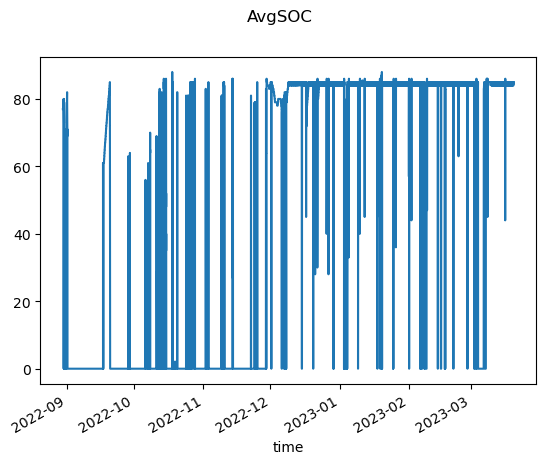

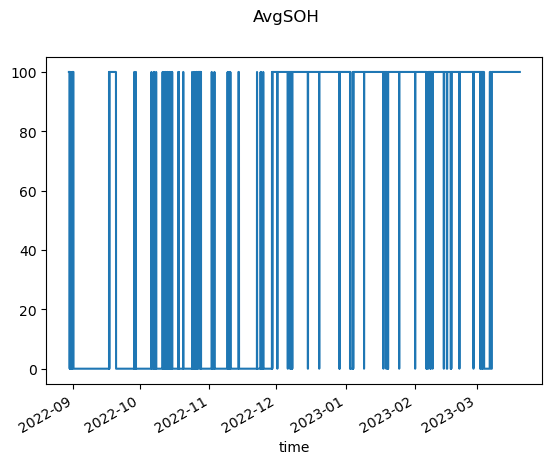

In [12]:
battery_data["AvgSOC"].plot()
plt.suptitle("AvgSOC")

plt.figure()
battery_data["AvgSOH"].plot()
plt.suptitle("AvgSOH")

## Preprocessing

In [13]:
hourly_data = battery_data[['AvgSOH']].resample('H').mean()
# hourly_data.plot()
hourly_data.dropna(inplace=True)

In [47]:
battery_data[battery_data["AVG_PACK_SOC"]==0].index

DatetimeIndex(['2022-10-17 00:00:00', '2022-10-17 00:01:00',
               '2022-10-17 00:02:00', '2022-10-17 00:03:00',
               '2022-10-17 00:04:00', '2022-10-17 00:05:00',
               '2022-10-17 00:06:00', '2022-10-17 00:07:00',
               '2022-10-17 00:08:00', '2022-10-17 00:09:00',
               ...
               '2023-03-07 12:53:00', '2023-03-07 12:54:00',
               '2023-03-07 12:55:00', '2023-03-07 12:56:00',
               '2023-03-07 12:57:00', '2023-03-07 12:58:00',
               '2023-03-07 12:59:00', '2023-03-07 13:00:00',
               '2023-03-07 13:01:00', '2023-03-07 13:02:00'],
              dtype='datetime64[ns]', name='time', length=6944, freq=None)

In [49]:
battery_data["NUMBER_OF_PACKS_FAULTED"].value_counts()

0.0     207306
1.0        488
80.0         1
5.0          1
Name: NUMBER_OF_PACKS_FAULTED, dtype: int64

In [55]:
fault_columns = battery_data.columns[battery_data.columns.str.endswith("FAULT")]
battery_data[battery_data["NUMBER_OF_PACKS_FAULTED"]==1][fault_columns].sum()

BATT_PACK_1_FAULT      0
BATT_PACK_2_FAULT    480
BATT_PACK_3_FAULT      0
BATT_PACK_4_FAULT      0
BATT_PACK_5_FAULT      0
BATT_PACK_6_FAULT      0
BATT_PACK_7_FAULT      0
dtype: object

In [57]:
battery_data[fault_columns].sum()

BATT_PACK_1_FAULT      99
BATT_PACK_2_FAULT     481
BATT_PACK_3_FAULT       1
BATT_PACK_4_FAULT       0
BATT_PACK_5_FAULT       1
BATT_PACK_6_FAULT    1085
BATT_PACK_7_FAULT    1084
dtype: object

In [14]:
hourly_data

,AvgSOH
time,
2022-08-30 00:00:00,100.0
2022-08-30 01:00:00,100.0
2022-08-30 02:00:00,100.0
2022-08-30 05:00:00,100.0
2022-08-30 06:00:00,100.0
...,...
2023-03-19 22:00:00,100.0
2023-03-19 23:00:00,100.0
2023-03-20 00:00:00,100.0


In [15]:
df.shape

(273961, 110)

In [16]:
minute_data = battery_data[['AvgSOH']].resample('5min').mean()
# hourly_data.plot()
minute_data.dropna(inplace=True)

In [17]:
minute_data

,AvgSOH
time,
2022-08-30 00:00:00,100.0
2022-08-30 00:05:00,100.0
2022-08-30 00:10:00,100.0
2022-08-30 00:15:00,100.0
2022-08-30 00:20:00,100.0
...,...
2023-03-20 02:10:00,100.0
2023-03-20 02:15:00,100.0
2023-03-20 02:20:00,100.0


In [18]:
# Calculate the index where we want to split the data
split_index = int(len(hourly_data) * 0.99)

# Split the DataFrame into train and test sets
train_data = hourly_data.iloc[:split_index]
test_data = hourly_data.iloc[split_index:]

In [19]:
test_data

,AvgSOH
time,
2023-03-18 05:00:00,100.0
2023-03-18 06:00:00,100.0
2023-03-18 07:00:00,100.0
2023-03-18 08:00:00,100.0
2023-03-18 09:00:00,100.0
2023-03-18 10:00:00,100.0
2023-03-18 11:00:00,100.0
2023-03-18 12:00:00,100.0
2023-03-18 13:00:00,100.0


In [20]:
print(train_data.shape)
print(test_data.shape)

(4544, 1)
(46, 1)


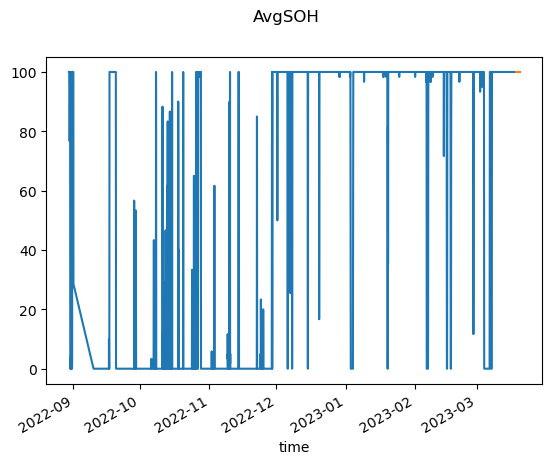

In [21]:
def plot_train_test(train_data, test_data, column):
    plt.figure()
    train_data[column].plot()
    test_data[column].plot()
    plt.suptitle(column)    

plot_train_test(train_data, test_data, "AvgSOH")
# plot_train_test(train_data, test_data, "AvgSOH")

# Exponential Smoothing forecast

In [96]:
# imports
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [51]:
SECONDS_IN_MINUTE = 60
SECONDS_IN_HOUR = 3600
SECONDS_IN_DAY = 86400
HOURS_IN_DAY = 24
HOURS_IN_WEEK = HOURS_IN_DAY*7

In [97]:
# Exponential Smoothing parameters

def get_exp_param_combinations():
    trend = ["add", "mul", None]
    damped_trend = [True, False]
    seasonal = ["add", "mul", None]
    seasonal_periods_seconds = [None, SECONDS_IN_MINUTE, SECONDS_IN_HOUR, SECONDS_IN_DAY]
    seasonal_periods_hour = [None, HOURS_IN_DAY, HOURS_IN_WEEK]
    use_boxcox = [True, False]

    param_combinations = []
    for t in trend:
        for d in damped_trend:
            for s in seasonal:
                for sp in seasonal_periods_hour:
                    for u in use_boxcox:
                        param_combination = {}
                        param_combination["trend"] = t
                        param_combination["damped_trend"] = d
                        param_combination["seasonal"] = s
                        param_combination["seasonal_periods"] = sp
                        param_combination["use_boxcox"] = u
                        param_combinations.append(param_combination)
    return param_combinations

exp_param_combinations = get_exp_param_combinations()

In [98]:
exp_param_combinations[0]

{'trend': 'add',
 'damped_trend': True,
 'seasonal': 'add',
 'seasonal_periods': None,
 'use_boxcox': True}

In [100]:
# Choose which target column you want to predict among ['change', 'end', 'start', 'high', 'low', 'volume', 'change(%)']
target_column = "AvgSOH"

# Create a list to store the evaluation results (e.g., mean squared error)
evaluation_results = []

# Define the number of splits for time series cross-validation
n_splits = 3

# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

model_scores = []

error_param_combinations = []

# Iterate over the parameter combinations
for param_combination in exp_param_combinations:
    # Perform time series cross-validation
    for train_index, test_index in tscv.split(train_data):
        try:
            # Split the data into training and testing sets
            y_train, y_test = train_data.iloc[train_index], train_data.iloc[test_index]
            
            # Extract the target values from the train and test sets
            y_train = y_train[target_column]
            y_test = y_test[target_column]
            
            # Create and fit the Exponential Smoothing model
            model = ExponentialSmoothing(y_train, **param_combination)
            fitted_model = model.fit()
            
            # Make predictions using the fitted model
            predictions = fitted_model.forecast(len(y_test))
            
            # Calculate the mean squared error for this fold
            mse = mean_squared_error(y_test, predictions)
            evaluation_results.append(mse)
        except:
            # Get the param combination that led to error
            error_param_combinations.append(param_combination)

    # Calculate the average mean squared error across all folds
    average_mse = np.mean(evaluation_results)
    model_scores.append((average_mse, param_combination))
model_scores.sort(key=lambda x: x[0])
best_parameters = model_scores[0][1]
best_model = ExponentialSmoothing(train_data[target_column], **best_parameters)
fitted_model = best_model.fit()
predictions = fitted_model.forecast(len(test_data[target_column]))
test_data[target_column].plot()
predictions.plot()
plt.legend(["Actual", "Predicted"])
rmse_exp = mean_squared_error(test_data[target_column], predictions, squared=False)
plt.suptitle(f"Exponential Smoothing rmse: {rmse_exp}")
print(best_parameters)

/home/user/miniconda3/envs/time_series_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/user/miniconda3/envs/time_series_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/user/miniconda3/envs/time_series_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/user/miniconda3/envs/time_series_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provide

ValueError: seasonal_periods has not been provided and index does not have a known freq. You must provide seasonal_periods

In [101]:
model_scores

[(nan,
  {'trend': 'add',
   'damped_trend': True,
   'seasonal': 'add',
   'seasonal_periods': None,
   'use_boxcox': True}),
 (nan,
  {'trend': 'add',
   'damped_trend': True,
   'seasonal': 'add',
   'seasonal_periods': None,
   'use_boxcox': False}),
 (nan,
  {'trend': 'add',
   'damped_trend': True,
   'seasonal': 'add',
   'seasonal_periods': 24,
   'use_boxcox': True}),
 (1497.03794154245,
  {'trend': 'add',
   'damped_trend': True,
   'seasonal': None,
   'seasonal_periods': 168,
   'use_boxcox': False}),
 (1497.03794154245,
  {'trend': 'add',
   'damped_trend': False,
   'seasonal': 'add',
   'seasonal_periods': None,
   'use_boxcox': True}),
 (1497.03794154245,
  {'trend': 'add',
   'damped_trend': False,
   'seasonal': 'add',
   'seasonal_periods': None,
   'use_boxcox': False}),
 (1497.03794154245,
  {'trend': 'add',
   'damped_trend': False,
   'seasonal': 'add',
   'seasonal_periods': 24,
   'use_boxcox': True}),
 (1515.2306940289309,
  {'trend': 'add',
   'damped_trend':

{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 168, 'use_boxcox': False}


/home/user/miniconda3/envs/time_series_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/user/miniconda3/envs/time_series_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


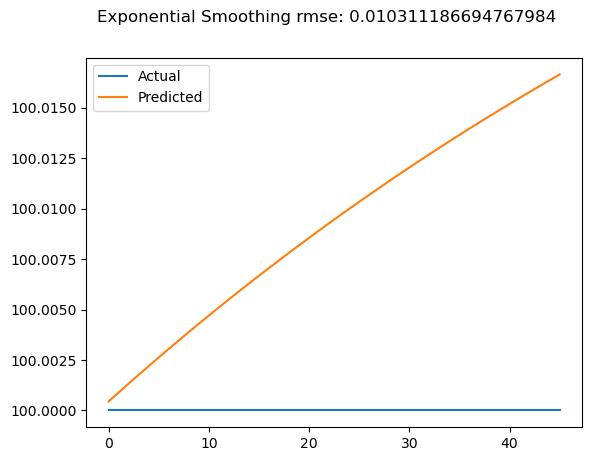

In [102]:
model_scores.sort(key=lambda x: x[0])
best_parameters = model_scores[3][1]
best_model = ExponentialSmoothing(train_data[target_column], **best_parameters)
fitted_model = best_model.fit()
predictions = fitted_model.forecast(len(test_data[target_column]))
test_data[target_column].reset_index(drop=True).plot()
predictions.reset_index(drop=True).plot()
plt.legend(["Actual", "Predicted"])
rmse_exp = mean_squared_error(test_data[target_column], predictions, squared=False)
plt.suptitle(f"Exponential Smoothing rmse: {rmse_exp}")
print(best_parameters)

{'trend': 'add', 'damped_trend': True, 'seasonal': None, 'seasonal_periods': 168, 'use_boxcox': False}


/home/user/miniconda3/envs/time_series_env/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


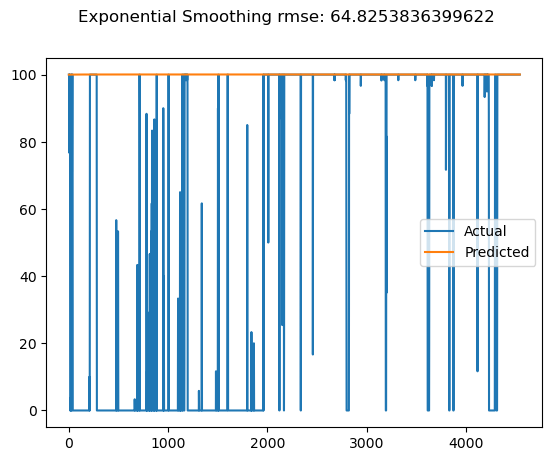

In [103]:
predictions_train = fitted_model.forecast(len(train_data[target_column]))
train_data[target_column].reset_index(drop=True).plot()
predictions_train.reset_index(drop=True).plot()
plt.legend(["Actual", "Predicted"])
rmse_exp = mean_squared_error(train_data[target_column], predictions_train, squared=False)
plt.suptitle(f"Exponential Smoothing rmse: {rmse_exp}")
print(best_parameters)

# Prophet forecast

/home/user/miniconda3/envs/time_series_env/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


03:16:32 - cmdstanpy - INFO - Chain [1] start processing
03:16:32 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


03:16:33 - cmdstanpy - INFO - Chain [1] start processing
03:16:33 - cmdstanpy - INFO - Chain [1] done processing
03:16:34 - cmdstanpy - INFO - Chain [1] start processing
03:16:34 - cmdstanpy - INFO - Chain [1] done processing
03:16:35 - cmdstanpy - INFO - Chain [1] start processing
03:16:35 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


03:16:35 - cmdstanpy - INFO - Chain [1] start processing
03:16:35 - cmdstanpy - INFO - Chain [1] done processing
03:16:36 - cmdstanpy - INFO - Chain [1] start processing
03:16:36 - cmdstanpy - INFO - Chain [1] done processing
03:16:37 - cmdstanpy - INFO - Chain [1] start processing
03:16:37 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:16:37 - cmdstanpy - INFO - Chain [1] start processing
03:16:37 - cmdstanpy - INFO - Chain [1] done processing
03:16:38 - cmdstanpy - INFO - Chain [1] start processing
03:16:38 - cmdstanpy - INFO - Chain [1] done processing
03:16:39 - cmdstanpy - INFO - Chain [1] start processing
03:16:39 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


03:16:39 - cmdstanpy - INFO - Chain [1] start processing
03:16:40 - cmdstanpy - INFO - Chain [1] done processing
03:16:40 - cmdstanpy - INFO - Chain [1] start processing
03:16:40 - cmdstanpy - INFO - Chain [1] done processing
03:16:41 - cmdstanpy - INFO - Chain [1] start processing
03:16:41 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


03:16:42 - cmdstanpy - INFO - Chain [1] start processing
03:16:42 - cmdstanpy - INFO - Chain [1] done processing
03:16:42 - cmdstanpy - INFO - Chain [1] start processing
03:16:42 - cmdstanpy - INFO - Chain [1] done processing
03:16:43 - cmdstanpy - INFO - Chain [1] start processing
03:16:43 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


03:16:44 - cmdstanpy - INFO - Chain [1] start processing
03:16:44 - cmdstanpy - INFO - Chain [1] done processing
03:16:45 - cmdstanpy - INFO - Chain [1] start processing
03:16:45 - cmdstanpy - INFO - Chain [1] done processing
03:16:46 - cmdstanpy - INFO - Chain [1] start processing
03:16:46 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


03:16:46 - cmdstanpy - INFO - Chain [1] start processing
03:16:46 - cmdstanpy - INFO - Chain [1] done processing
03:16:47 - cmdstanpy - INFO - Chain [1] start processing
03:16:47 - cmdstanpy - INFO - Chain [1] done processing
03:16:48 - cmdstanpy - INFO - Chain [1] start processing
03:16:48 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


03:16:48 - cmdstanpy - INFO - Chain [1] start processing
03:16:48 - cmdstanpy - INFO - Chain [1] done processing
03:16:49 - cmdstanpy - INFO - Chain [1] start processing
03:16:49 - cmdstanpy - INFO - Chain [1] done processing
03:16:50 - cmdstanpy - INFO - Chain [1] start processing
03:16:50 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


03:16:51 - cmdstanpy - INFO - Chain [1] start processing
03:16:51 - cmdstanpy - INFO - Chain [1] done processing
03:16:51 - cmdstanpy - INFO - Chain [1] start processing
03:16:52 - cmdstanpy - INFO - Chain [1] done processing
03:16:52 - cmdstanpy - INFO - Chain [1] start processing
03:16:53 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


03:16:53 - cmdstanpy - INFO - Chain [1] start processing
03:16:53 - cmdstanpy - INFO - Chain [1] done processing
03:16:54 - cmdstanpy - INFO - Chain [1] start processing
03:16:54 - cmdstanpy - INFO - Chain [1] done processing
03:16:55 - cmdstanpy - INFO - Chain [1] start processing
03:16:55 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:16:55 - cmdstanpy - INFO - Chain [1] start processing
03:16:55 - cmdstanpy - INFO - Chain [1] done processing
03:16:56 - cmdstanpy - INFO - Chain [1] start processing
03:16:56 - cmdstanpy - INFO - Chain [1] done processing
03:16:57 - cmdstanpy - INFO - Chain [1] start processing
03:16:57 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


03:16:58 - cmdstanpy - INFO - Chain [1] start processing
03:16:58 - cmdstanpy - INFO - Chain [1] done processing
03:16:59 - cmdstanpy - INFO - Chain [1] start processing
03:16:59 - cmdstanpy - INFO - Chain [1] done processing
03:17:00 - cmdstanpy - INFO - Chain [1] start processing
03:17:00 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


03:17:00 - cmdstanpy - INFO - Chain [1] start processing
03:17:00 - cmdstanpy - INFO - Chain [1] done processing
03:17:01 - cmdstanpy - INFO - Chain [1] start processing
03:17:01 - cmdstanpy - INFO - Chain [1] done processing
03:17:02 - cmdstanpy - INFO - Chain [1] start processing
03:17:02 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


03:17:02 - cmdstanpy - INFO - Chain [1] start processing
03:17:02 - cmdstanpy - INFO - Chain [1] done processing
03:17:03 - cmdstanpy - INFO - Chain [1] start processing
03:17:03 - cmdstanpy - INFO - Chain [1] done processing
03:17:04 - cmdstanpy - INFO - Chain [1] start processing
03:17:04 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


03:17:05 - cmdstanpy - INFO - Chain [1] start processing
03:17:05 - cmdstanpy - INFO - Chain [1] done processing
03:17:06 - cmdstanpy - INFO - Chain [1] start processing
03:17:06 - cmdstanpy - INFO - Chain [1] done processing
03:17:07 - cmdstanpy - INFO - Chain [1] start processing
03:17:07 - cmdstanpy - INFO - Chain [1] done processing


Testing hyperparameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


03:17:07 - cmdstanpy - INFO - Chain [1] start processing
03:17:07 - cmdstanpy - INFO - Chain [1] done processing
03:17:08 - cmdstanpy - INFO - Chain [1] start processing
03:17:08 - cmdstanpy - INFO - Chain [1] done processing
03:17:09 - cmdstanpy - INFO - Chain [1] start processing


Testing hyperparameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


03:17:09 - cmdstanpy - INFO - Chain [1] done processing
03:17:10 - cmdstanpy - INFO - Chain [1] start processing
03:17:11 - cmdstanpy - INFO - Chain [1] done processing
03:17:11 - cmdstanpy - INFO - Chain [1] start processing
03:17:12 - cmdstanpy - INFO - Chain [1] done processing
03:17:13 - cmdstanpy - INFO - Chain [1] start processing


Testing hyperparameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


03:17:13 - cmdstanpy - INFO - Chain [1] done processing
03:17:13 - cmdstanpy - INFO - Chain [1] start processing
03:17:14 - cmdstanpy - INFO - Chain [1] done processing
03:17:15 - cmdstanpy - INFO - Chain [1] start processing
03:17:16 - cmdstanpy - INFO - Chain [1] done processing
03:17:16 - cmdstanpy - INFO - Chain [1] start processing


Testing hyperparameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


03:17:17 - cmdstanpy - INFO - Chain [1] done processing
03:17:17 - cmdstanpy - INFO - Chain [1] start processing
03:17:18 - cmdstanpy - INFO - Chain [1] done processing
03:17:18 - cmdstanpy - INFO - Chain [1] start processing
03:17:19 - cmdstanpy - INFO - Chain [1] done processing
03:17:20 - cmdstanpy - INFO - Chain [1] start processing


Testing hyperparameters: {'changepoint_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


03:17:21 - cmdstanpy - INFO - Chain [1] done processing
03:17:21 - cmdstanpy - INFO - Chain [1] start processing
03:17:22 - cmdstanpy - INFO - Chain [1] done processing
03:17:23 - cmdstanpy - INFO - Chain [1] start processing
03:17:24 - cmdstanpy - INFO - Chain [1] done processing
03:17:24 - cmdstanpy - INFO - Chain [1] start processing
03:17:25 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 0.98, 'Prophet rmse: 6.022521678088337')

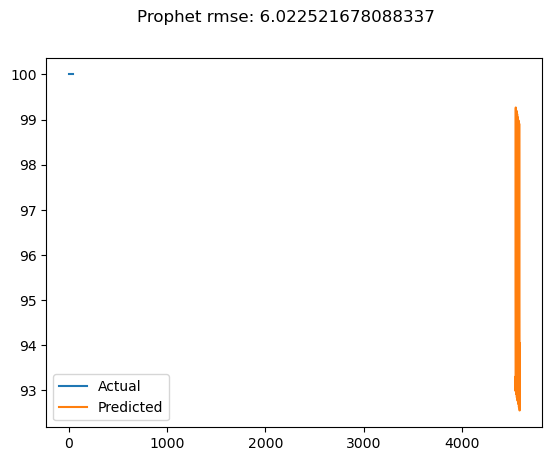

In [22]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

# Create a list to store the evaluation results (e.g., mean squared error)
evaluation_results = []

# Define the number of splits for time series cross-validation
n_splits = 3

# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

target_column = "AvgSOH"

model_scores = []

# Define a parameter grid with hyperparameters to tune
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

error_param_combinations = []


# Prepare data
train_data_prophet = train_data.copy()
train_data_prophet["ds"] = train_data_prophet.index
train_data_prophet["y"] = train_data_prophet[target_column]


for param_combination in list(ParameterGrid(param_grid))[:20]:
    print("Testing hyperparameters:", param_combination)
    # Perform time series cross-validation
    for train_index, test_index in tscv.split(train_data_prophet):
        try:
            # Split the data into training and testing sets
            y_train, y_test = train_data_prophet.iloc[train_index], train_data_prophet.iloc[test_index]
            
            # Create and fit the Prophet model with the current hyperparameters
            model = Prophet(seasonality_mode=param_combination['seasonality_mode'],
                            seasonality_prior_scale=param_combination['seasonality_prior_scale'],
                            changepoint_prior_scale=param_combination['changepoint_prior_scale'])
            model.fit(y_train[['ds', 'y']])
            
            # Make future date predictions for the testing period
            future = model.make_future_dataframe(periods=len(y_test))
            forecast = model.predict(future)
            
            # Extract the actual and predicted values for the testing period
            y_test = y_test[target_column].values
            y_pred = forecast['yhat'].tail(len(y_test)).values
            
            # Calculate the mean squared error for this fold
            mse = mean_squared_error(y_test, y_pred)
            evaluation_results.append(mse)
        except:
            error_param_combinations.append(param_combination)

    # Calculate the average mean squared error across all folds
    average_mse = np.mean(evaluation_results)
    model_scores.append((average_mse, param_combination))

# Create best model
model_scores.sort(key=lambda x: x[0])
best_parameters = model_scores[0][1]
best_model = Prophet(seasonality_mode=best_parameters['seasonality_mode'],
                    seasonality_prior_scale=best_parameters['seasonality_prior_scale'],
                    changepoint_prior_scale=best_parameters['changepoint_prior_scale'])
best_model.fit(train_data_prophet[['ds', 'y']])

# Make future date predictions for the testing period
future = best_model.make_future_dataframe(periods=len(test_data))
forecast = best_model.predict(future)
# forecast = forecast['yhat'].tail(len(test_data))
forecast.reset_index(drop=True, inplace=True)
pd.Series(test_data[target_column].values).plot()
forecast['yhat'].tail(len(test_data)).plot()
plt.legend(["Actual", "Predicted"])
prophet_rmse = mean_squared_error(test_data[target_column], forecast['yhat'].tail(len(test_data)), squared=False)
plt.suptitle(f"Prophet rmse: {prophet_rmse}")

Text(0.5, 0.98, 'Prophet rmse: 6.022521678088337')

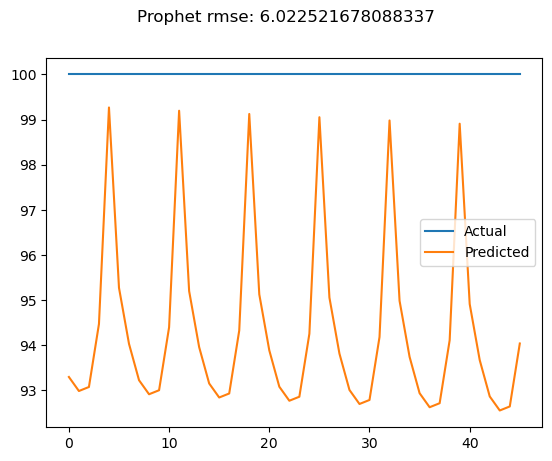

In [24]:
pd.Series(test_data[target_column].values).plot()
forecast['yhat'].tail(len(test_data)).reset_index(drop=True).plot()
plt.legend(["Actual", "Predicted"])
prophet_rmse = mean_squared_error(test_data[target_column], forecast['yhat'].tail(len(test_data)), squared=False)
plt.suptitle(f"Prophet rmse: {prophet_rmse}")

Text(0.5, 0.98, 'Prophet rmse: 29.766475652697196')

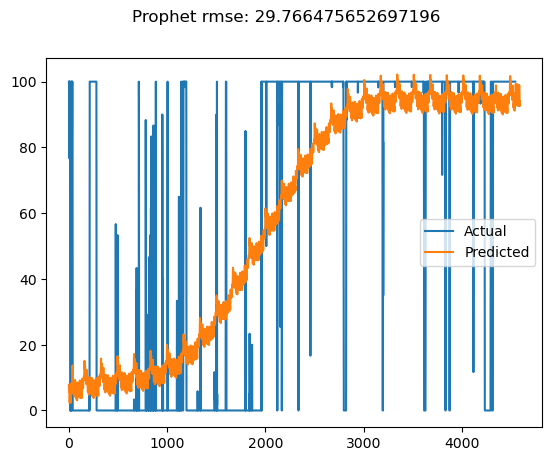

In [28]:
train_data["AvgSOH"].reset_index(drop=True).plot()
forecast["yhat"].plot()
plt.legend(["Actual", "Predicted"])
prophet_rmse = mean_squared_error(train_data[target_column], forecast['yhat'][:len(train_data)], squared=False)
plt.suptitle(f"Prophet rmse: {prophet_rmse}")

# LSTM

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import keras.callbacks
from keras import backend as K

2023-08-18 03:20:03.681514: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
def make_lookback_dataset(dataset, look_back, forecast_steps):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-forecast_steps):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset.iloc[i+look_back:i+look_back+forecast_steps])
    dataY = np.array(dataY)
    dataY = dataY.reshape(len(dataY), dataY.shape[1])
    return np.array(dataX, dtype=float), np.array(dataY, dtype=float)

def run_lstm_pipeline(X_train, y_train, forecast_steps, epochs):
    """Runs the prophet model with default parameters

    Args:
        X_train (pd.DataFrame): Glucose features for training
        y_train (pd.DataFrame): Glucose labels for training
        X_test (pd.DataFrame): Glucose features for testing
        y_test (pd.DataFrame): Glucose labels for testing
        
    Returns:
        resuls (tuple): train_pred, train_mse, test_pred, test_mse
    """
    model = Sequential()
    model.add(LSTM(50, return_sequences=True,  input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50))
    # model.add(LSTM(10, return_sequences=True))
    # model.add(LSTM(10))
    model.add(Dense(forecast_steps))
    adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss="mse", optimizer='adam')
    # Early stopping
    es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                min_delta=0,
                                patience=2,
                                verbose=1, mode='auto')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1, shuffle=False)
    return model, history

def scale_data(data, scaler):
    reshaped_data = data.flatten()
    dim = data.shape[0] * data.shape[1]
    reshaped_data = np.arange(dim).reshape(-1, 1)
    scaled_data = scaler.transform(reshaped_data)
    return scaled_data.reshape(data.shape)

def compute_rmse(y_train, train_pred, y_test, test_pred):
    train_score = np.sqrt(mean_squared_error(y_train, train_pred))
    test_score = np.sqrt(mean_squared_error(y_test, test_pred))
    return train_score, test_score

def make_predictions(model, X_train, X_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    return train_pred, test_pred

def print_rmse(train_rmse, test_rmse):
    print('Train RMSE: %.3f' % train_rmse)
    print('Test RMSE: %.3f' % test_rmse)

def plot_predictions(y_train, train_pred, y_test, test_pred, forecast_step):
    """
    forecast_step (int): the forecast step I want to plot from the predictions
    """
    plt.figure()
    plt.plot(y_train[:,forecast_step], linewidth=2)
    plt.plot(train_pred[:,forecast_step], linewidth=2)
    plt.legend(["actual", "predicted"])
    plt.figure()
    plt.plot(y_test[:,forecast_step], linewidth=2)
    plt.plot(test_pred[:,forecast_step], linewidth=2)
    plt.legend(["actual", "predicted"])

/home/user/miniconda3/envs/time_series_env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/user/miniconda3/envs/time_series_env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
2023-08-18 03:23:02.815392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 03:23:02.816320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this messa

Epoch 1/20


2023-08-18 03:23:02.946785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 03:23:02.948779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 03:23:02.950220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

138/138 [==============================] - 6s 26ms/step - loss: 0.1456
Epoch 2/20
138/138 [==============================] - 3s 23ms/step - loss: 0.1764
Epoch 3/20
138/138 [==============================] - 3s 23ms/step - loss: 0.1657
Epoch 4/20
138/138 [==============================] - 3s 21ms/step - loss: 0.2368
Epoch 5/20
138/138 [==============================] - 3s 25ms/step - loss: 0.2309
Epoch 6/20
138/138 [==============================] - 3s 21ms/step - loss: 0.2330
Epoch 7/20
138/138 [==============================] - 3s 23ms/step - loss: 0.2676
Epoch 8/20
138/138 [==============================] - 3s 23ms/step - loss: 0.2715
Epoch 9/20
138/138 [==============================] - 3s 24ms/step - loss: 0.2630
Epoch 10/20
138/138 [==============================] - 3s 21ms/step - loss: 0.2019
Epoch 11/20
138/138 [==============================] - 3s 23ms/step - loss: 0.2130
Epoch 12/20
138/138 [==============================] - 3s 21ms/step - loss: 0.2031
Epoch 13/20
138/138 [===

2023-08-18 03:24:08.396744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 03:24:08.398333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 03:24:08.399251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 11ms/step
Train RMSE: 52.452
Test RMSE: 103.145
------------------------------------------------------------------------------


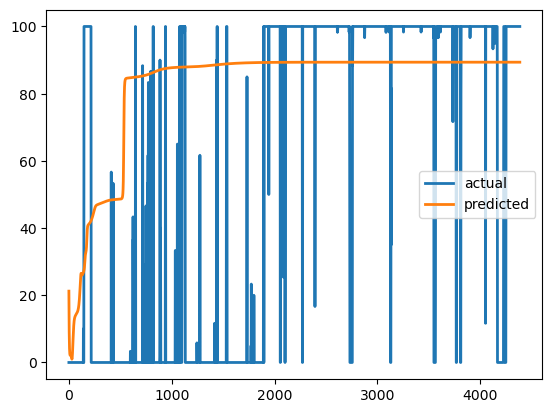

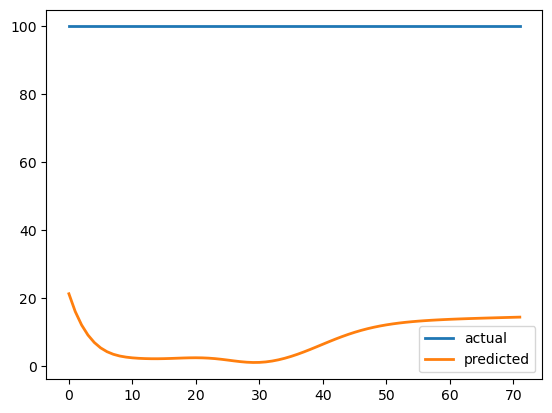

In [33]:
# Implementing multi forecast
LOOK_BACK = 20

FORECAST_STEPS = 46
EPOCHS = 20
FORECAST_STEP_TO_PRINT = 45
patients_data = []
original_glucoses = []

train_sets = []
X_trains = []
y_trains = []
train_preds = []
train_rmses = []
test_sets = []
X_tests = []
y_tests = []
test_preds = []
test_rmses = []
histories = []

errors = []
error_patients = []

# Calculate the index where we want to split the data
split_index = int(len(hourly_data) * 0.97)

# Split the DataFrame into train and test sets
train_data_lstm = hourly_data.iloc[:split_index].copy()
test_data_lstm = hourly_data.iloc[split_index:].copy()

# Make lookback datasets for LSTM
X_train, y_train = make_lookback_dataset(train_data_lstm[target_column], LOOK_BACK, FORECAST_STEPS)
X_test, y_test = make_lookback_dataset(test_data_lstm[target_column], LOOK_BACK, FORECAST_STEPS)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Scale data to range [0, 1]
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
train_set = scaler_X.fit_transform(train_data_lstm[[target_column]])
scaler_y = scaler_y.fit(y_train)
X_train = scale_data(X_train, scaler_X)
X_test = scale_data(X_test, scaler_X)
y_train = scaler_y.transform(y_train)

# Train model
model, history = run_lstm_pipeline(X_train, y_train, FORECAST_STEPS, EPOCHS)

# Make predictions
train_pred, test_pred = make_predictions(model, X_train, X_test)
train_pred = scaler_y.inverse_transform(train_pred)
test_pred = scaler_y.inverse_transform(test_pred)
y_train = scaler_y.inverse_transform(y_train)

# Postprocessing
train_rmse, test_rmse = compute_rmse(y_train, train_pred, y_test, test_pred)
print_rmse(train_rmse, test_rmse)
plot_predictions(y_train, train_pred, y_test, test_pred, FORECAST_STEP_TO_PRINT)
print("------------------------------------------------------------------------------")

In [74]:
y_train.shape

(271181, 20)

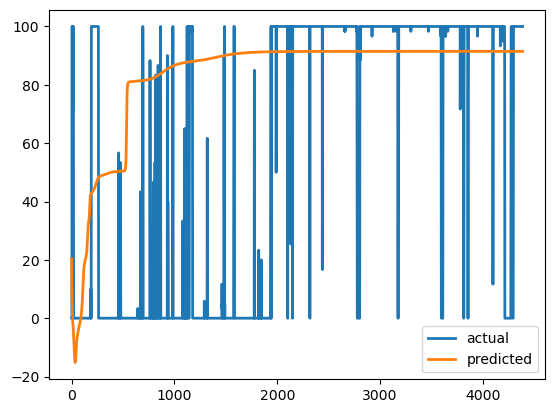

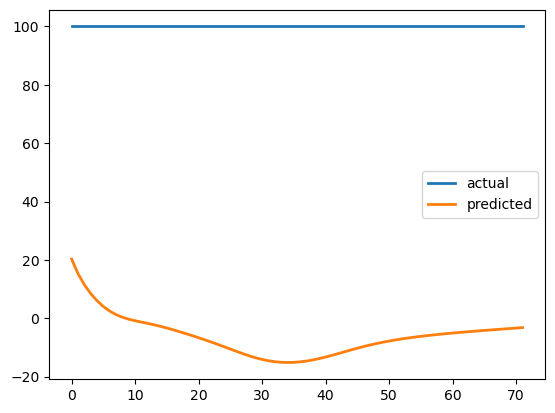

In [40]:
# Choose which prediction you want to plot from 0 to 19
plot_predictions(y_train, train_pred, y_test, test_pred, 0)